# In Depth A/B Testing - Lab

## Introduction

In this lab, you'll explore a survey from Kaggle regarding budding data scientists. With this, you'll form some initial hypotheses, and test them using the tools you've acquired to date. 

## Objectives

You will be able to:
* Conduct statistical tests on a real-world dataset

## Load the Dataset and Perform a Brief Exploration

The data is stored in a file called **multipleChoiceResponses_cleaned.csv**. Feel free to check out the original dataset referenced at the bottom of this lab, although this cleaned version will undoubtedly be easier to work with. Additionally, meta-data regarding the questions is stored in a file name **schema.csv**. Load in the data itself as a Pandas DataFrame, and take a moment to briefly get acquainted with it.

> Note: If you can't get the file to load properly, try changing the encoding format as in `encoding='latin1'`

In [1]:
#Your code here
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns

data = pd.read_csv('multipleChoiceResponses_cleaned.csv')
metadata = pd.read_csv('schema.csv')
data.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity,exchangeRate,AdjustedCompensation
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,NaN,NaN
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,250000.0
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
metadata.head()

,Column,Question,Asked
0,GenderSelect,Select your gender identity. - Selected Choice,All
1,GenderFreeForm,Select your gender identity. - A different ide...,All
2,Country,Select the country you currently live in.,All
3,Age,What's your age?,All
4,EmploymentStatus,What's your current employment status?,All


## Wages and Education

You've been asked to determine whether education is impactful to salary. Develop a hypothesis test to compare the salaries of those with Master's degrees to those with Bachelor's degrees. Are the two statistically different according to your results?

> Note: The relevant features are stored in the 'FormalEducation' and 'AdjustedCompensation' features.

In [3]:
data[['FormalEducation','AdjustedCompensation']].head(10)

,FormalEducation,AdjustedCompensation
0,Bachelor's degree,NaN
1,Master's degree,NaN
2,Master's degree,NaN
3,Master's degree,250000.0
4,Doctoral degree,NaN
5,Doctoral degree,NaN
6,Master's degree,NaN
7,Bachelor's degree,NaN
8,Bachelor's degree,64184.8
9,Bachelor's degree,20882.4


In [4]:
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    x1_bar = a.mean()
    var1 = a.var(ddof=1) 
    n1 = len(a)
    
    x2_bar = b.mean()
    var2 = b.var(ddof=1) 
    n2 = len(b)
    
    t = np.abs(x1_bar - x2_bar) / np.sqrt(var1/n1 + var2/n2) 
    
    return t

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    var1 = a.var(ddof=1) 
    n1 = len(a)
    
    var2 = b.var(ddof=1) 
    n2 = len(b)
    
    df = (var1/n1 + var2/n2)**2 / ((var1**2/((n1-1)*n1**2)) + (var2**2/((n2-1)*n2**2)))
    return df #Return the degrees of freedom

In [5]:
#Your code here

# H0: the salaries of those with bachelor's degree equal the salaries of those with master's degree
# Ha: the salaries of those with bachelor's degree are less than the salaries of those with master's degree

bachelors = data[(data['FormalEducation']=="Bachelor's degree") & 
             ~(data['AdjustedCompensation'].isnull())]['AdjustedCompensation']
masters = data[(data['FormalEducation']=="Master's degree") & 
             ~(data['AdjustedCompensation'].isnull())]['AdjustedCompensation']

t = welch_t(bachelors, masters)
df = welch_df(bachelors, masters)
p = 1 - stats.t.cdf(t, df)


print("Comparison of AdjustedCompensation for Bachelor's degree and Master's degree")
print("Median Values: \ts1: {} \ts2: {}".format(round(bachelors.median(),2), round(masters.median(),2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(bachelors.mean(),2), round(masters.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(bachelors), len(masters)))
print("Welch's t-test p-value:", p)

Comparison of AdjustedCompensation for Bachelor's degree and Master's degree
Median Values: 	s1: 38399.4 	s2: 53812.17
Mean Values: 	s1: 64887.1 	s2: 69139.9
Sample sizes: 	s1: 1107 	s2: 1990
Welch's t-test p-value: 0.33077639451272267


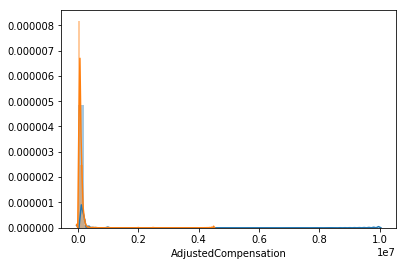

In [6]:
sns.distplot(bachelors)
sns.distplot(masters)

In [7]:
#Investigate Percentiles
for q in np.linspace(.8, 1, num=21):
    bachelors_q =  round(bachelors.quantile(q=q), 2)
    masters_q =  round(masters.quantile(q=q), 2)
    print('{}th percentile:\tset1: {}\tset2: {}'.format(round(q,2), bachelors_q, masters_q))

0.8th percentile:	set1: 93233.13	set2: 103000.0
0.81th percentile:	set1: 95572.83	set2: 107009.0
0.82th percentile:	set1: 99276.38	set2: 110000.0
0.83th percentile:	set1: 100000.0	set2: 111503.83
0.84th percentile:	set1: 103040.0	set2: 115240.4
0.85th percentile:	set1: 105935.04	set2: 119582.6
0.86th percentile:	set1: 110000.0	set2: 120000.0
0.87th percentile:	set1: 112000.0	set2: 124719.88
0.88th percentile:	set1: 115000.0	set2: 129421.46
0.89th percentile:	set1: 120000.0	set2: 130000.0
0.9th percentile:	set1: 120346.5	set2: 135000.0
0.91th percentile:	set1: 126460.0	set2: 140000.0
0.92th percentile:	set1: 132615.4	set2: 149640.0
0.93th percentile:	set1: 140000.0	set2: 150000.0
0.94th percentile:	set1: 143408.8	set2: 160000.0
0.95th percentile:	set1: 150000.0	set2: 166778.6
0.96th percentile:	set1: 179849.74	set2: 180000.0
0.97th percentile:	set1: 195000.0	set2: 200000.0
0.98th percentile:	set1: 200000.0	set2: 211100.0
0.99th percentile:	set1: 250000.0	set2: 250000.0
1.0th percentile:

In [8]:
# Repeated test with samples without outliers
outlier_thres = 500000

bachelors2 = bachelors[bachelors < outlier_thres]
masters2 = masters[masters < outlier_thres]

t2 = welch_t(bachelors2, masters2)
df2 = welch_df(bachelors2, masters2)
p2 = 1 - stats.t.cdf(t2, df2)

print("Comparison of AdjustedCompensation for Bachelor's degree and Master's degree, Adjusted for outliers")
print("Median Values: \ts1: {} \ts2: {}".format(round(bachelors2.median(),2), round(masters2.median(),2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(bachelors2.mean(),2), round(masters2.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(bachelors2), len(masters2)))
print("Welch's t-test p-value:", p2)

Comparison of AdjustedCompensation for Bachelor's degree and Master's degree, Adjusted for outliers
Median Values: 	s1: 38292.15 	s2: 53445.86
Mean Values: 	s1: 53744.35 	s2: 63756.86
Sample sizes: 	s1: 1103 	s2: 1984
Welch's t-test p-value: 6.694760973369185e-07


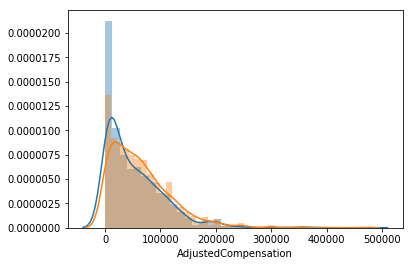

In [9]:
sns.distplot(bachelors2)
sns.distplot(masters2)

## Wages and Education II

Now perform a similar statistical test comparing the AdjustedCompensation of those with Bachelor's degrees and those with Doctorates. If you haven't already, be sure to explore the distribution of the AdjustedCompensation feature for any anomalies. 

In [10]:
#Your code here

# H0: the salaries of those with bachelor's degree equal the salaries of those with doctoral degree
# Ha: the salaries of those with bachelor's degree are less than the salaries of those with doctoral degree

bachelors = data[(data['FormalEducation']=="Bachelor's degree") & 
             ~(data['AdjustedCompensation'].isnull())]['AdjustedCompensation']
doctoral = data[(data['FormalEducation']=="Doctoral degree") & 
             ~(data['AdjustedCompensation'].isnull())]['AdjustedCompensation']

t = welch_t(bachelors, doctoral)
df = welch_df(bachelors, doctoral)
p = 1 - stats.t.cdf(t, df)


print("Comparison of AdjustedCompensation for Bachelor's degree and Doctoral degree")
print("Median Values: \ts1: {} \ts2: {}".format(round(bachelors.median(),2), round(doctoral.median(),2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(bachelors.mean(),2), round(doctoral.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(bachelors), len(doctoral)))
print("Welch's t-test p-value:", p)

Comparison of AdjustedCompensation for Bachelor's degree and Doctoral degree
Median Values: 	s1: 38399.4 	s2: 74131.92
Mean Values: 	s1: 64887.1 	s2: 29566175.76
Sample sizes: 	s1: 1107 	s2: 967
Welch's t-test p-value: 0.1568238199472023


In [11]:
#Investigate Percentiles
for q in np.linspace(.8, 1, num=21):
    bachelors_q =  round(bachelors.quantile(q=q), 2)
    doctoral_q =  round(doctoral.quantile(q=q), 2)
    print('{}th percentile:\tset1: {}\tset2: {}'.format(round(q,2), bachelors_q, doctoral_q))

0.8th percentile:	set1: 93233.13	set2: 135000.0
0.81th percentile:	set1: 95572.83	set2: 140000.0
0.82th percentile:	set1: 99276.38	set2: 140000.0
0.83th percentile:	set1: 100000.0	set2: 146796.17
0.84th percentile:	set1: 103040.0	set2: 150000.0
0.85th percentile:	set1: 105935.04	set2: 150000.0
0.86th percentile:	set1: 110000.0	set2: 155000.0
0.87th percentile:	set1: 112000.0	set2: 160000.0
0.88th percentile:	set1: 115000.0	set2: 160000.0
0.89th percentile:	set1: 120000.0	set2: 166480.0
0.9th percentile:	set1: 120346.5	set2: 172057.78
0.91th percentile:	set1: 126460.0	set2: 175000.0
0.92th percentile:	set1: 132615.4	set2: 181555.2
0.93th percentile:	set1: 140000.0	set2: 191900.0
0.94th percentile:	set1: 143408.8	set2: 200000.0
0.95th percentile:	set1: 150000.0	set2: 200000.0
0.96th percentile:	set1: 179849.74	set2: 220999.61
0.97th percentile:	set1: 195000.0	set2: 240879.14
0.98th percentile:	set1: 200000.0	set2: 277349.78
0.99th percentile:	set1: 250000.0	set2: 336800.0
1.0th percentil

In [12]:
# Repeated test with samples without outliers
outlier_thres = 500000

bachelors2 = bachelors[bachelors < outlier_thres]
doctoral2 = doctoral[doctoral < outlier_thres]

t2 = welch_t(bachelors2, doctoral2)
df2 = welch_df(bachelors2, doctoral2)
p2 = 1 - stats.t.cdf(t2, df2)

print("Comparison of AdjustedCompensation for Bachelor's degree and Doctoral degree, Adjusted for outliers")
print("Median Values: \ts1: {} \ts2: {}".format(round(bachelors2.median(),2), round(doctoral2.median(),2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(bachelors2.mean(),2), round(doctoral2.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(bachelors2), len(doctoral2)))
print("Welch's t-test p-value:", p2)

Comparison of AdjustedCompensation for Bachelor's degree and Doctoral degree, Adjusted for outliers
Median Values: 	s1: 38292.15 	s2: 73152.77
Mean Values: 	s1: 53744.35 	s2: 86194.98
Sample sizes: 	s1: 1103 	s2: 964
Welch's t-test p-value: 0.0


## Wages and Education III

Remember the multiple comparisons problem; rather than continuing on like this, perform an ANOVA test between the various 'FormalEducation' categories and their relation to 'AdjustedCompensation'.

In [13]:
#Your code here
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'AdjustedCompensation ~ C(FormalEducation)'
lm = ols(formula, data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df         F    PR(>F)
C(FormalEducation)  6.540294e+17     6.0  0.590714  0.738044
Residual            7.999414e+20  4335.0       NaN       NaN


In [14]:
data2 = data[data['AdjustedCompensation'] <= 500000]
formula = 'AdjustedCompensation ~ C(FormalEducation)'
lm = ols(formula, data2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df          F        PR(>F)
C(FormalEducation)  5.841881e+11     6.0  29.224224  1.727132e-34
Residual            1.439270e+13  4320.0        NaN           NaN


## Additional Resources

Here's the original source where the data was taken from:  
    [Kaggle Machine Learning & Data Science Survey 2017](https://www.kaggle.com/kaggle/kaggle-survey-2017)

## Summary

In this lab, you practiced conducting actual hypothesis tests on actual data. From this, you saw how dependent results can be on the initial problem formulation, including preprocessing!